# Econometric Analysis of Physical Moments with PyDerivatives 5.0

This tutorial showcases the **econometrics module of PyDerivatives 5.0** to analyze the behavior of **physical return moments** derived from option-implied densities after transformation from the risk-neutral to the physical measure.

Our objective is to study the **dynamic, nonlinear, and state-dependent behavior** of physical variance, skewness, and kurtosis, and their interactions with asset returns and with one another.

---

## Data Description

We analyze option-implied physical moments constructed from daily option surfaces over the sample period:

- **Sample period:** 2021-06-01 to 2024-08-01

### Assets

The following assets are examined:

- **GLD** — Gold ETF  
- **SPY** — S&P 500 ETF  
- **SLV** — Silver ETF  
- **XLE** — Energy Sector ETF  
- **BTC** — Bitcoin options traded on Deribit  

For each asset, option prices are used to estimate forward-looking physical return distributions at fixed horizons, from which physical moments are extracted.

---

## Econometric Methodology

We replicate and extend several econometric techniques commonly used in the recent asset pricing and derivatives literature to study higher-order moments.

---

### 1. Wavelet Coherence Between Returns and Physical Moments

We begin by examining the **time–frequency dependence** between asset returns and physical moments using **wavelet coherence analysis**.

Wavelet methods allow us to:
- Identify short- and long-run dependence  
- Detect regime changes  
- Study horizon-specific comovement  

This approach is particularly well-suited for financial time series characterized by non-stationarity and multiscale dynamics, and provides an intuitive first look at how returns and higher-order moments co-move across time and investment horizons.

---

### 2. Time-Varying Quantile Regressions of Physical Moments

To study **dynamic interdependencies among moments**, we next estimate **time-varying quantile regressions** in which physical moments are regressed onto other physical moments.

This framework captures:
- Nonlinear spillovers across moments  
- Time-variation in dependence structures  
- Heterogeneity across quantiles  

Such models are especially useful for understanding how tail risk and higher-order risks propagate across assets and moments over time.

---

### 3. Quantile Regressions of Physical Moments on Returns

Finally, we estimate **quantile regressions** of physical moments onto contemporaneous and lagged log returns to capture **state-dependent and asymmetric responses** across the conditional distribution.

This approach allows us to examine how moments such as variance, skewness, and kurtosis respond differently during negative versus positive return regimes and across market states, highlighting limitations of mean-based regression models.

---


In [1]:
import warnings
%pip install git+https://github.com/Julian-Beatty/Pyderivatives.git
from pyderivatives import*
import matplotlib.dates as mdates
from importlib.resources import files


  Running command git clone --filter=blob:none --quiet https://github.com/Julian-Beatty/Pyderivatives.git 'C:\Users\beatt\AppData\Local\Temp\pip-req-build-x3g0b6cc'


  Cloning https://github.com/Julian-Beatty/Pyderivatives.git to c:\users\beatt\appdata\local\temp\pip-req-build-x3g0b6cc
  Resolved https://github.com/Julian-Beatty/Pyderivatives.git to commit 809468f3e38e680c5d7cc8bfcc73e47c5e195527
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


In [2]:
def load_moments_by_asset():
    """
    Load the packaged demo pickle: moments_returns.pkl
    """
    p = files("pyderivatives.demodata") / "moments_returns.pkl"
    with p.open("rb") as f:
        return pickle.load(f)

obj = load_moments_by_asset()
moments_premia_dict=obj["moments_by_asset"]
logreturns=obj["btc_logreturns"]

## Wavelet Coherence Analysis

We begin our analysis with **wavelet coherence plots** examining the relationship between **Bitcoin log returns** and its **higher-order physical moments** (variance, skewness, and kurtosis).

Wavelet coherence measures the **local correlation between two time series simultaneously in the time and frequency domains**, allowing us to identify periods and horizons over which returns and moments exhibit strong comovement. Unlike time-domain methods, wavelet techniques are well-suited for financial data characterized by non-stationarity, regime changes, and multiscale dynamics.

High coherence values indicate strong local dependence at a given time and frequency, while phase differences provide information on the **lead–lag structure** between returns and higher-order moments.

---

Our implementation and visualization closely replicate wavelet-based analyses in the cryptocurrency literature, particularly:

- **Kumar, Anoop S., and Suvvari Anandarao (2019)**  
  *Volatility spillover in cryptocurrency markets: Some evidences from GARCH and wavelet analysis*,  
  *Physica A: Statistical Mechanics and its Applications*, 524, 448–458.

Consistent with this literature, the wavelet coherence results reveal that the dependence between Bitcoin returns and higher-order moments is **both time-varying and horizon-dependent**, with stronger comovement observed during periods of heightened market stress and at shorter investment horizons.

---



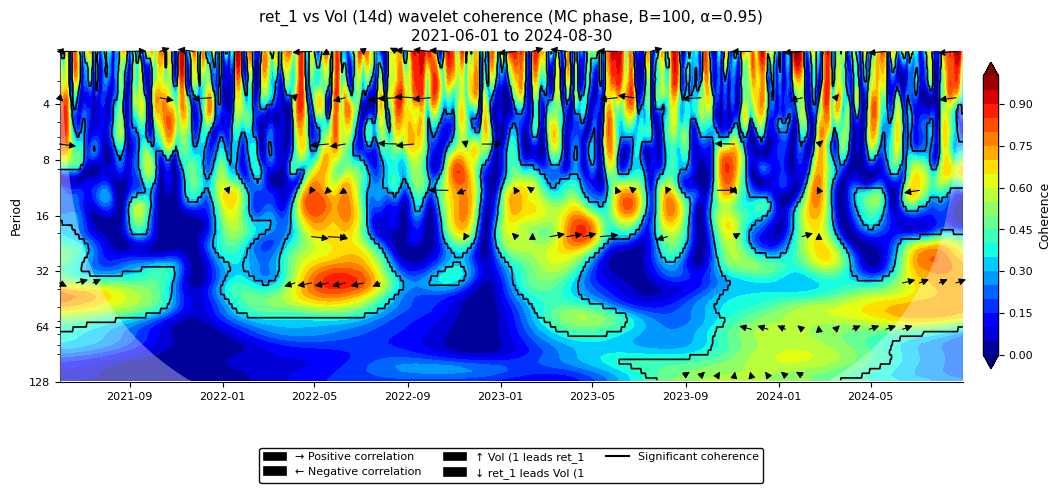

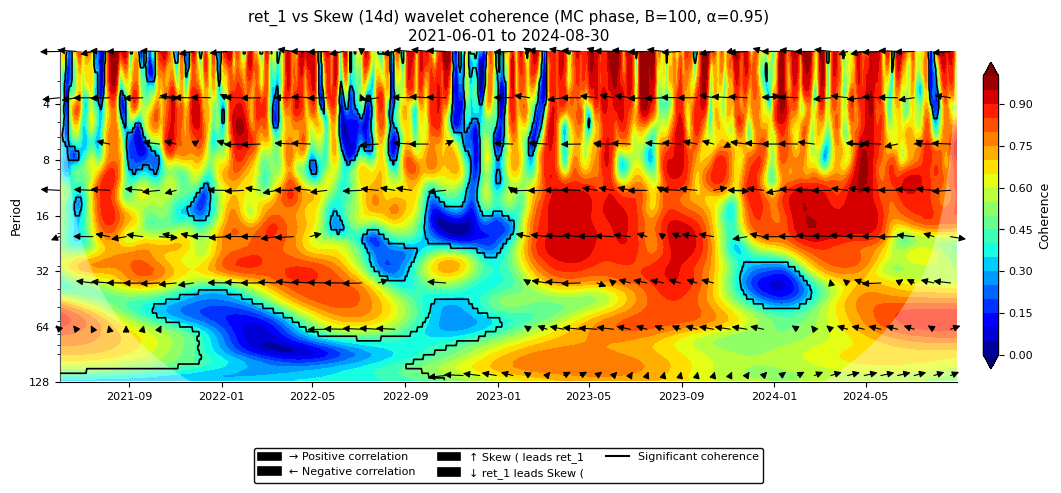

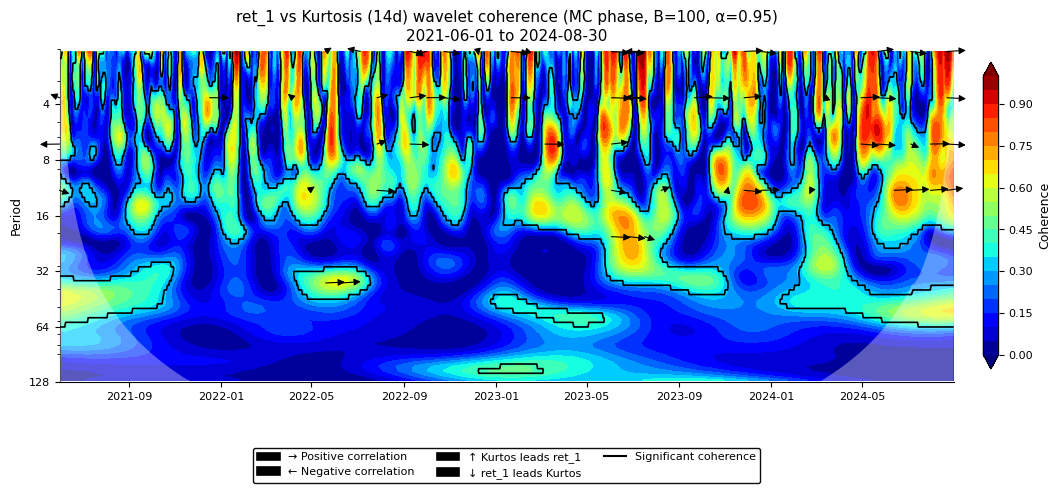

In [3]:
specs = [
    ("Vol (14d)",  moments_premia_dict["BTC"][14]["phys_vol_ann"],  "wtc_var.png"),
    ("Skew (14d)", moments_premia_dict["BTC"][14]["phys_skew"], "wtc_skew.png"),
    ("Kurtosis (14d)", moments_premia_dict["BTC"][14]["phys_kurt"], "wtc_kurt.png"),
]

# --- 1) Generate each WTC plot and save as image ---
for title, ydata, fname in specs:
    fig_i, ax_i = plot_wtc(
        logreturns, ydata,
        x_name="ret_1",
        y_name=title,
        value_col_x="ret_1",
        transform="none",
        detrend=True,
        sig=True,
        sig_method="mc-phase",
        mc_B=100,
        mc_alpha=0.95,
        period_max=128,
    )


## Related Literature and Replication Framework

The econometric procedures implemented in this tutorial are motivated by and closely follow methodologies proposed in the following studies:

- **Hibbert, Ann Marie, Robert T. Daigler, and Brice Dupoyet (2008)**  
  *A behavioral explanation for the negative asymmetric return–volatility relation*,  
  *Journal of Banking & Finance*, 32(10), 2254–2266.

- **Yang, Can, and Zhen Fang (2025)**  
  *The asymmetric relationships between returns and higher-order moments: Evidence from the Bitcoin market*,  
  *Applied Economics*, forthcoming.

These studies document strong **asymmetric and state-dependent relationships** between asset returns and higher-order distributional moments, particularly volatility, skewness, and kurtosis. A central insight of this literature is that negative return realizations tend to be associated with disproportionate changes in higher moments, reflecting leverage effects, behavioral responses, and tail-risk re-pricing.

Following this framework, we employ **quantile-based econometric techniques** to capture nonlinear and asymmetric dependencies that are not observable under mean-based regression approaches. In addition, we extend the analysis to a multisc


In [8]:
assymetric_moments_dict={}
investment_horizon=[7,14,21,28,35,60]
for horizon in investment_horizon:
    assymetric_moments_dict[horizon]= run_asym_quantreg_with_controls(
        r_df=logreturns,            
        var_s=moments_premia_dict["BTC"][horizon]["phys_vol_ann"],
        skew_s=moments_premia_dict["BTC"][horizon]["phys_skew"],
        kurt_s=moments_premia_dict["BTC"][horizon]["phys_kurt"],
        ret_col="ret_1",
        n_controls_lags=2,
        n_ret_lags=2,
        n_mom_lags=2,
        B=2,
        block_len=10)
    
    
result_dict={"7d":assymetric_moments_dict[7],"14d":assymetric_moments_dict[14],"21d":assymetric_moments_dict[21],
     "28d":assymetric_moments_dict[28],"35d":assymetric_moments_dict[35],"60d":assymetric_moments_dict[60]}



C:\Users\beatt\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
C:\Users\beatt\anaconda3\Lib\site-packages\pyderivatives\post_estimation\generalizedquantilesreg.py:232: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p_boot_norm = t_boot.applymap(pval_from_t)
C:\Users\beatt\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
C:\Users\beatt\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
C:\Users\beatt\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regres

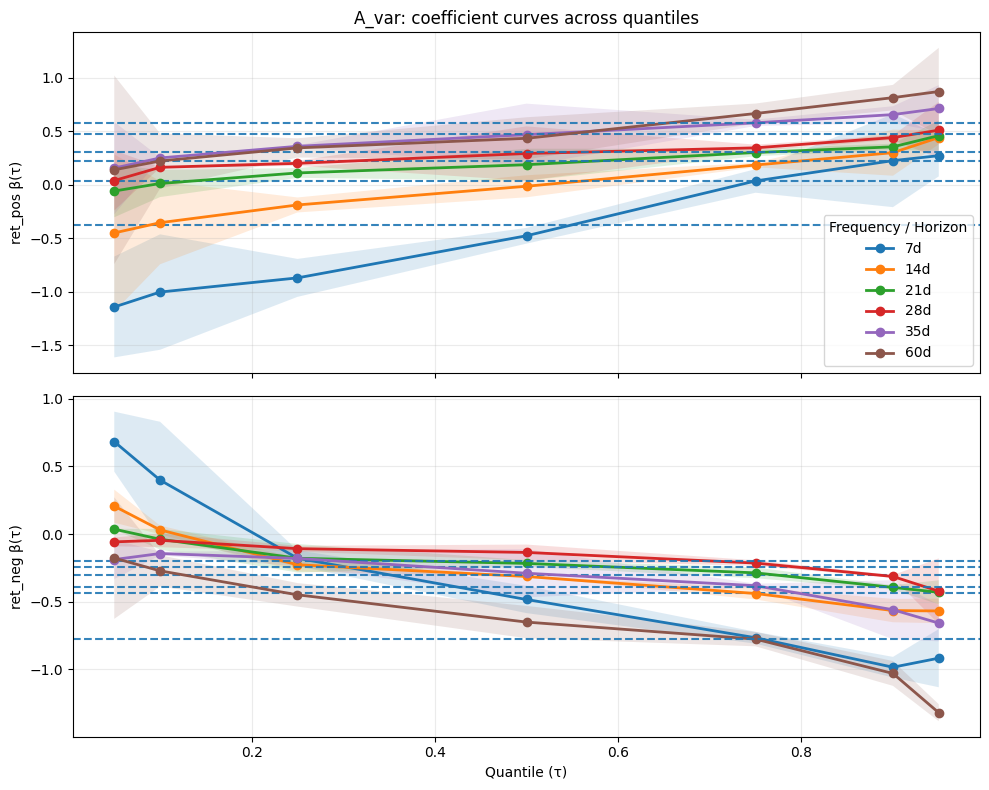

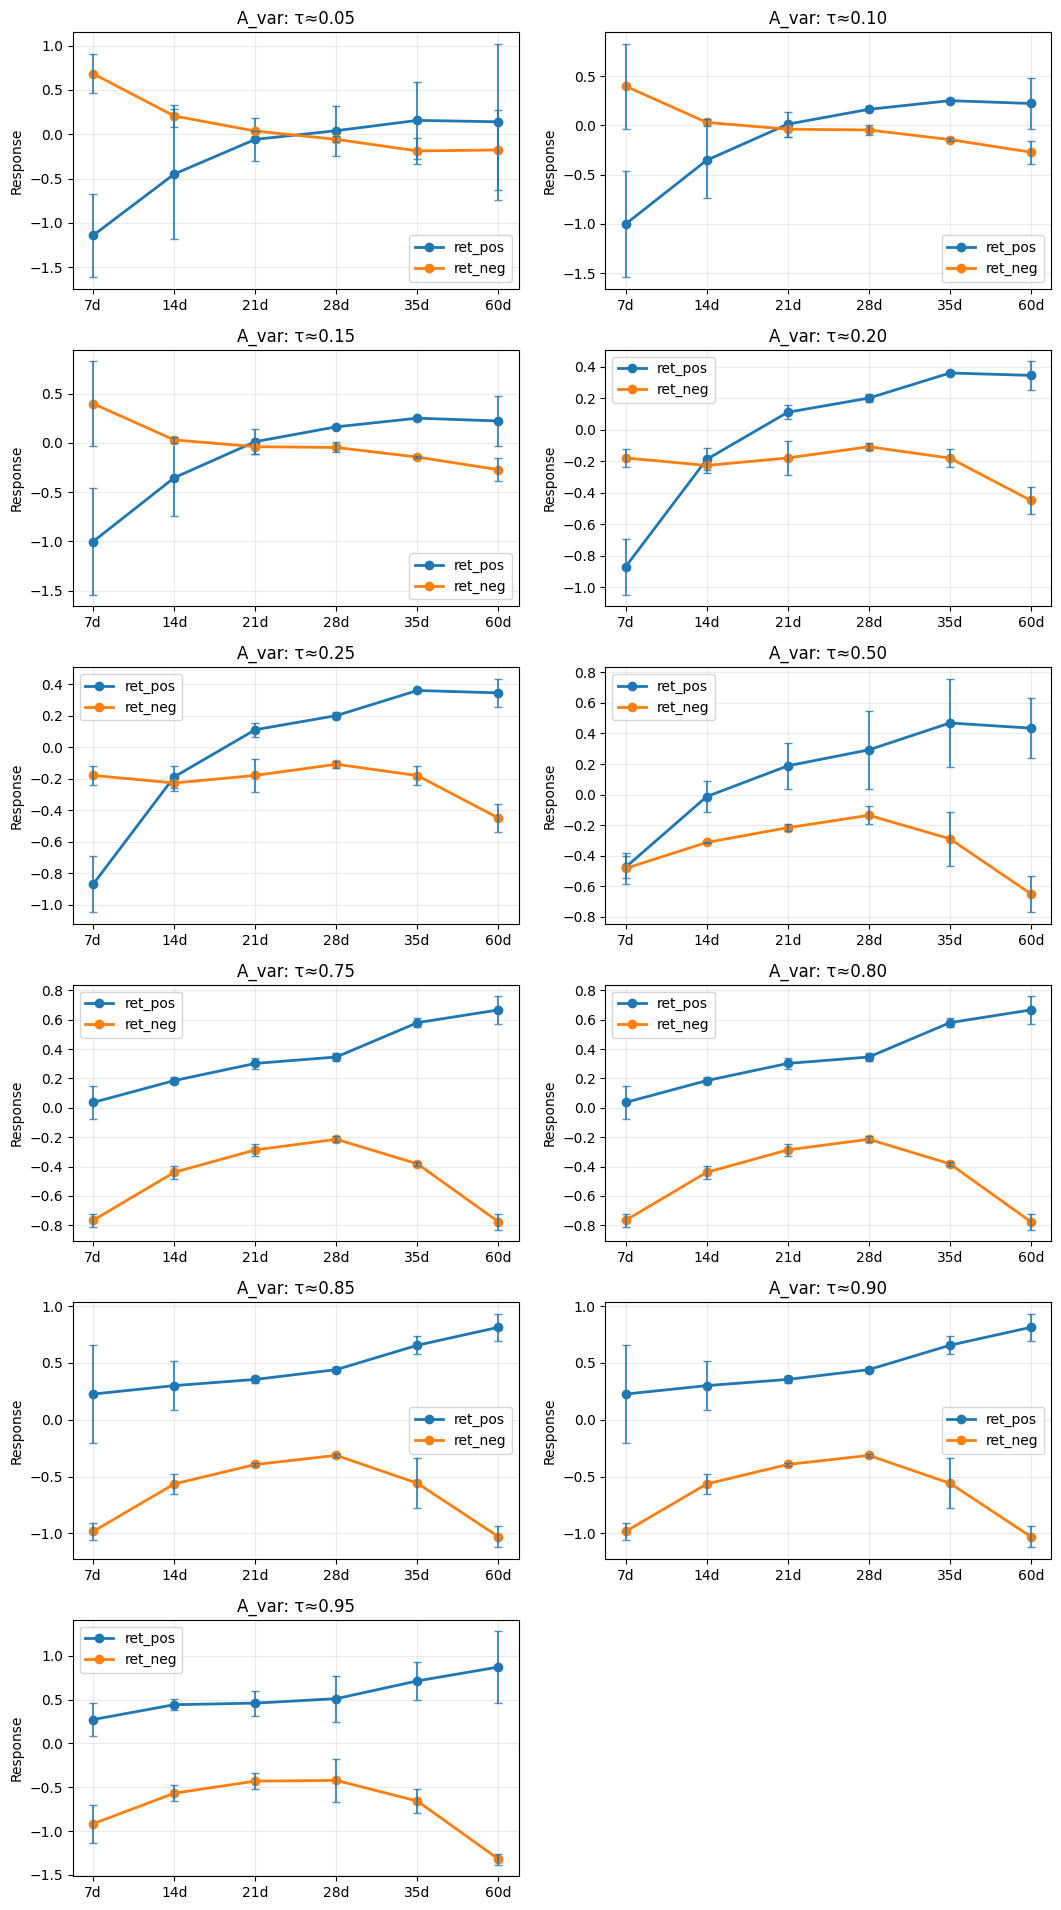

In [5]:
fig, axes = plot_qrm_across_quantiles_selectcoef(
    res_by_key=result_dict,
    eq_key="A_var",
    coefs=("ret_pos","ret_neg"),          
    ci=0.95,
    show_ols=True,
    ols_hac_lags=10,
)
fig, axes = plot_qrm_by_quantile_across_frequencies_selectcoef(
     res_by_key=result_dict,
    eq_key="A_var",
    coefs=("ret_pos","ret_neg"),  # any controls you added
    ci=0.95,
    show_ols=False,
)

## Interpretation of Results

From the first two figures, we observe that **negative returns exert a markedly different effect on physical moments than positive returns**, highlighting pronounced asymmetry in the return–moment relationship. Moreover, the magnitude and even the direction of this effect are **quantile-dependent**, underscoring the limitations of a simple OLS framework, which masks heterogeneity across the conditional distribution.

In the second panel, the results further reveal that the estimated relationships **vary substantially across maturities**, indicating that the response of physical moments is strongly horizon-dependent. This finding is consistent with the notion that risk perceptions and tail sensitivities differ across investment horizons.




## Spillover Analysis Across Assets

We now analyze the **spillover effects** among the assets under study—**Bitcoin (BTC), Silver (SLV), Gold (GLD), Energy (XLE), and the S&P 500 (SPY)**—with a particular focus on the transmission of higher-order physical moments across markets.

To capture **dynamic, nonlinear, and tail-dependent spillovers**, we employ a **Time-Varying Quantile Vector Autoregression (TVQVAR)** framework. This approach allows dependence structures to evolve over time while simultaneously accommodating heterogeneity across different parts of the conditional distribution.

---

## Methodological Framework

The TVQVAR model extends the standard VAR framework in two important dimensions:

1. **Quantile Dependence**  
   Rather than modeling conditional means, the system is estimated at multiple quantiles, enabling us to study spillovers under:
   - Normal market conditions (central quantiles)
   - Downside risk states (lower quantiles)
   - Extreme market stress (upper quantiles)

2. **Time Variation**  
   Model parameters are allowed to evolve over time, capturing structural changes, regime shifts, and evolving cross-market linkages.

This framework is particularly well-suited for financial markets, where spillovers are known to be **state-dependent**, **nonlinear**, and **time-varying**.

---

## Related Literature and Replication Targets

Our implementation closely follows recent contributions in the spillover and quantile VAR literature, including:

- **Raza, Syed Ali, Maiyra Ahmed, and Sajid Ali (2026)**  
  *Untangling Market Links: A QVAR–TVP VAR Analysis of Precious Metals and Oil Amid the Pandemic*,  
  *Journal of Futures Markets*, 46(1), 101–120.

- **Azimli, Asil (2024)**  
  *Time-varying spillovers in higher-order moments among cryptocurrencies*,  
  *Financial Innovation*, 10(1), 96.

These studies demonstrate that spillovers intensify during periods of market stress and differ substantially across quantiles and moments. In particular, higher-order moments such as skewness and kurtosis exhibit stronger and more persistent cross-market transmission than mean returns.

---

## Empirical Focus

In line with this literature, we use the TVQVAR framework to examine:
- Directional spillovers across assets
- Asymmetries between downside and upside risk states
- The evolution of cross-asset dependence over time
- Differences in spillover intensity across higher-order moments

The resulting connectedness measures provide a comprehensive view of how tail risks and higher-order risks propagate across major asset classes.


In [6]:
moments_by_asset=moments_premia_dict=obj["moments_by_asset"]
taus = [0.10, 0.25, 0.50, 0.75, 0.90]
roll_dict = {}
static_dict = {}

feature_list = ["phys_vol_ann", "phys_skew", "phys_kurt",]
investment_horizon=[14]

C:\Users\beatt\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
C:\Users\beatt\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
C:\Users\beatt\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
C:\Users\beatt\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
C:\Users\beatt\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regressio

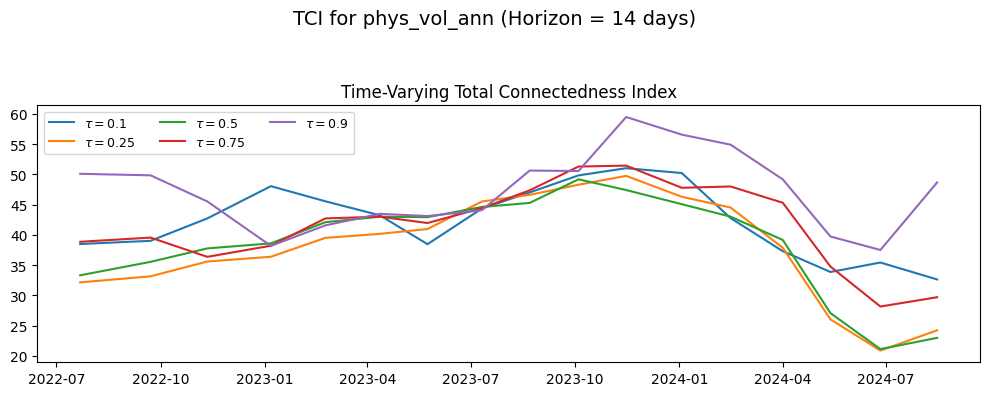

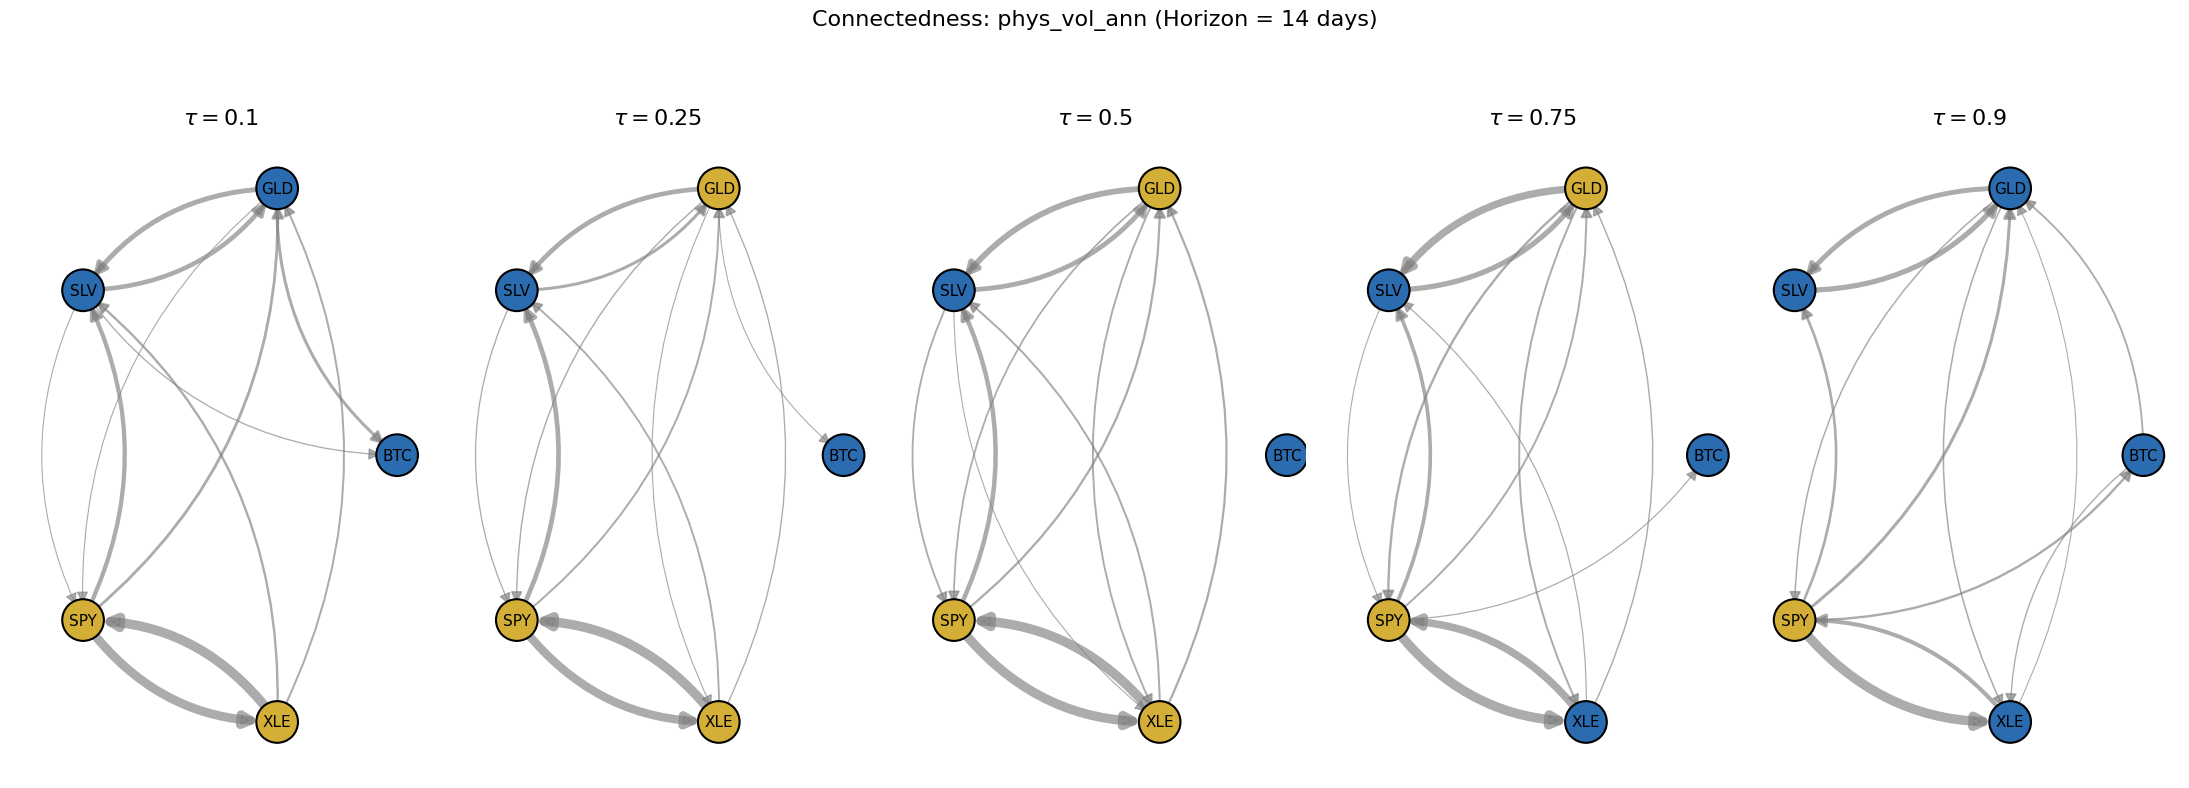

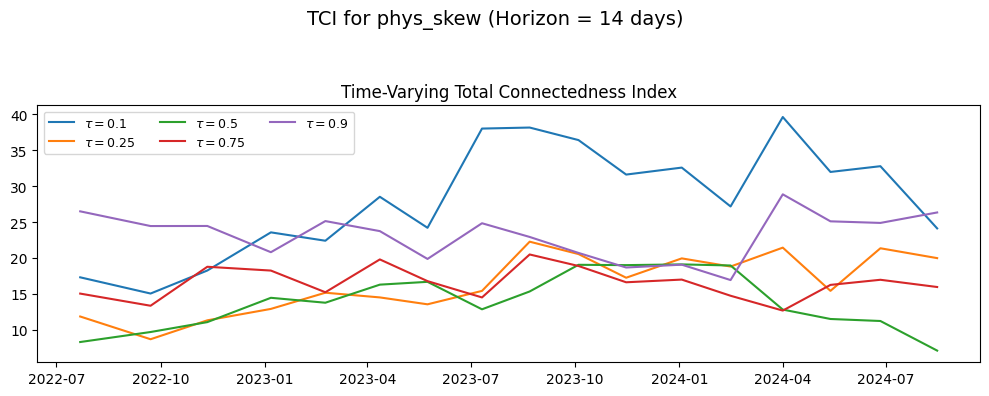

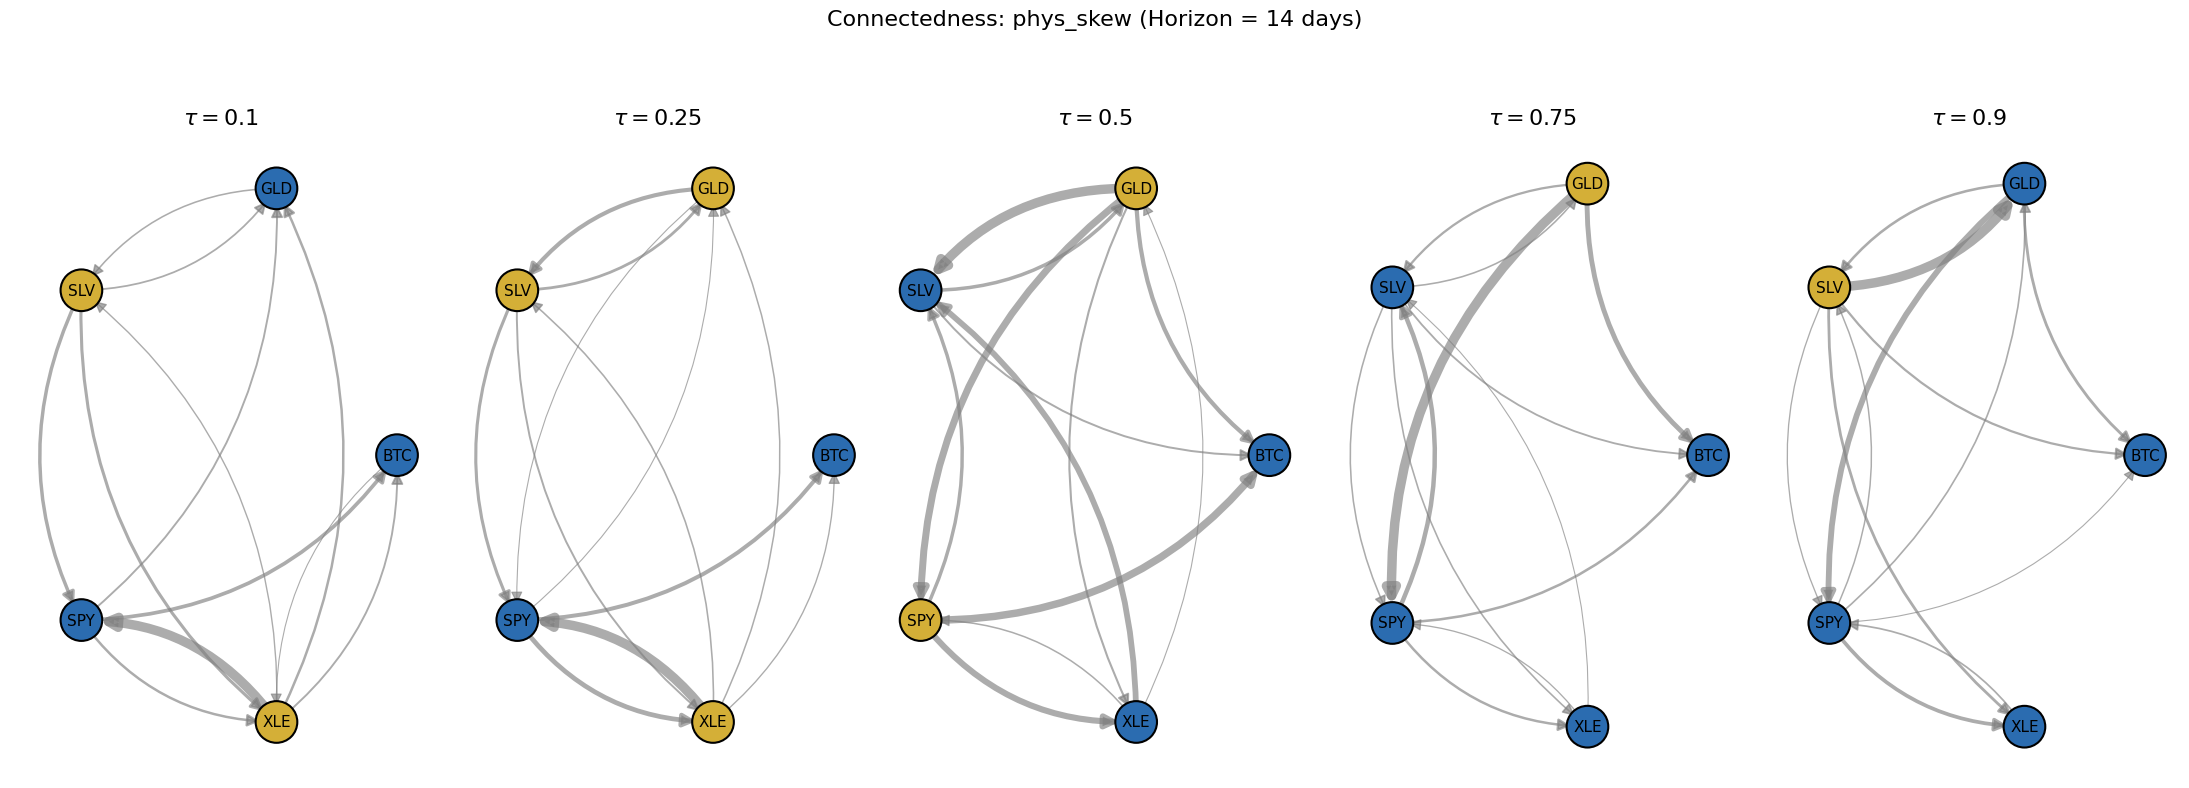

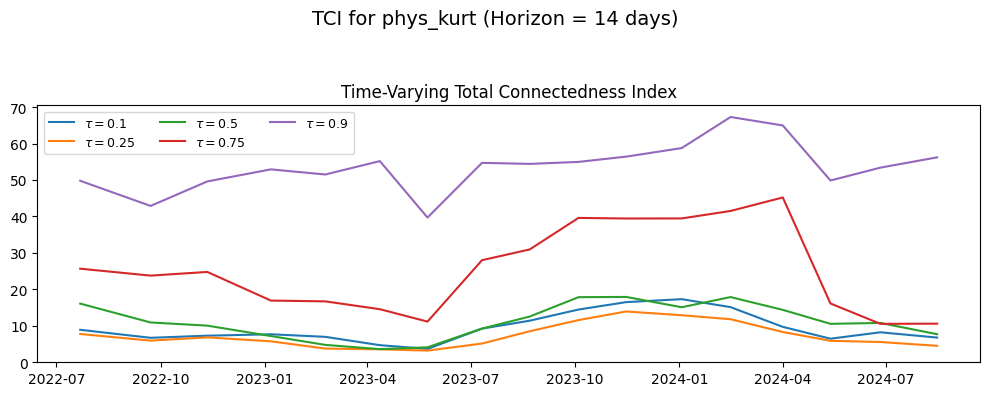

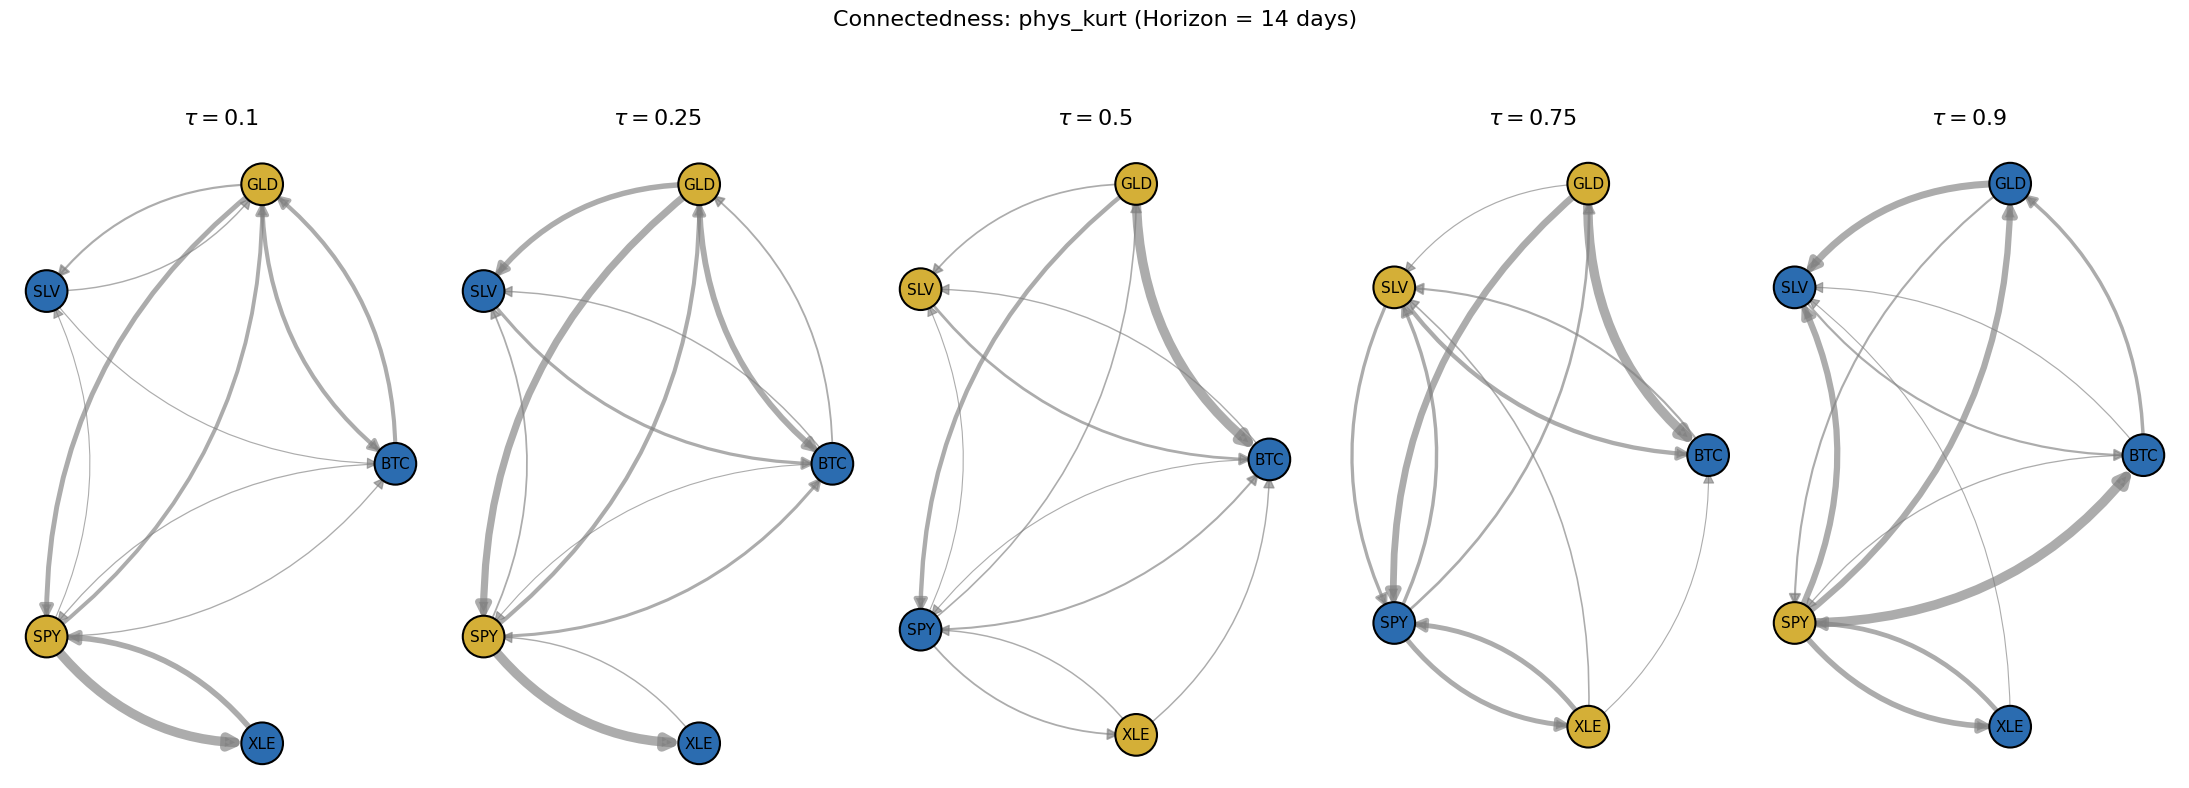

In [7]:
for horizon in investment_horizon:
    roll_dict[horizon] = {}
    static_dict[horizon] = {}

    for feature in feature_list:
        # ---- panel: only the feature across assets ----
        df = build_feature_panel(moments_by_asset, horizon=horizon, feature=feature)
        dfz = zscore(df).dropna()

        if len(dfz) < 260:
            print(f"Skipping {feature} H={horizon}: only {len(dfz)} rows.")
            continue

        # ---- rolling ----
        roll = rolling_quantile_connectedness(
            dfz, taus=taus, p=1, H=10, window=250, step=30
        )
        roll_dict[horizon][feature] = roll

        # ---- static stats for table + networks ----
        static = {tau: quantile_connectedness(dfz, tau=tau, p=1, H=10) for tau in taus}
        static_dict[horizon][feature] = static




        # =========================
        # (B) TCI figure
        # =========================
        fig_tci, ax = plt.subplots(figsize=(10, 4))
        for tau in roll.tci.columns:
            ax.plot(roll.tci.index, roll.tci[tau], label=f"$\\tau={tau}$")

        ax.legend(ncol=3, fontsize=9)
        ax.set_title("Time-Varying Total Connectedness Index")
        fig_tci.suptitle(f"TCI for {feature} (Horizon = {horizon} days)", fontsize=14)
        fig_tci.tight_layout(rect=[0, 0, 1, 0.92])


        # =========================
        # (C) Network panels
        # =========================
        fig_net, axes = plt.subplots(1, len(taus), figsize=(22, 8))
        if len(taus) == 1:
            axes = [axes]

        for ax_i, tau in zip(axes, taus):
            st = static[tau]
            Theta = pd.DataFrame(st.Theta, index=dfz.columns, columns=dfz.columns)
            net   = pd.Series(st.NET, index=dfz.columns)

            plot_spillover_network_arc_on_ax(
                ax_i,
                Theta,
                net=net,
                title=f"$\\tau={tau}$",
                top_k=12,
                curvature=0.25
            )

        fig_net.suptitle(f"Connectedness: {feature} (Horizon = {horizon} days)", fontsize=16)
        fig_net.tight_layout(rect=[0, 0, 1, 0.92])

## Interpretation of Time-Varying Connectedness Results

The **time-varying connectedness index**, computed separately for each quantile, measures the **percentage of forecast error variance** of a given variable that can be attributed to shocks originating from **other assets in the system**, rather than to its own innovations. Higher values therefore indicate stronger cross-market dependence and a greater role for spillovers.

The **connectedness web** provides a graphical representation of **directional spillovers**, illustrating which assets act as **net transmitters** or **net receivers** of shocks at a given point in time and quantile. Importantly, these relationships are **conditional**, **quantile-specific**, and **time-varying**, and should not be interpreted as structural or causal effects.

Using **14-day option-implied physical moments**, the results indicate that **Bitcoin primarily behaves as a net receiver of shocks**, with its forecast error variance being largely explained by innovations originating from **Gold (GLD)** and **SPY**, rather than from Energy (XLE) or Silver (SLV). This suggests that, at short horizons, Bitcoin’s higher-order risk dynamics are more closely linked to broad equity market conditions and safe-haven assets than to commodity-specific factors.

Overall, these findings highlight the importance of **horizon-dependent and quantile-dependent spillover analysis**, as the role of Bitcoin within the cross-asset network varies substantially across market states and investment horizons.
